In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

### Load source data

In [222]:
stock_price = pd.read_csv(r'c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\stock_price.csv', parse_dates = ['Date'])

In [223]:
stock_price.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2019-03-18,113.029999,114.000000,112.459999,113.120003,111.754234,21769800,DIS
1,2019-03-19,112.949997,113.709999,109.800003,110.000000,108.671898,45384400,DIS
2,2019-03-20,110.309998,110.879997,108.050003,109.989998,108.662018,35588700,DIS


In [230]:
vader = pd.read_pickle(r"c:\Users\jaromir\OneDrive\UoM\100_Disertation\02_SrcData\03_TMP\VADER.pkl")

In [224]:
vader.head(3)

,text,date,ticker,filtered_text,VADER_polarity,VADER_score,VADER_sentiment
0,$AMZN $GOOG $AAPL $MSFT Google is the best.......,2020-06-18,DIS,$AMZN $GOOG $AAPL $MSFT Google is the best ...,"{'neg': 0.0, 'neu': 0.924, 'pos': 0.076, 'comp...",0.6369,1
1,A lot of people ask me what I’m currently in a...,2020-06-18,DIS,A lot of people ask me what I’m currently in a...,"{'neg': 0.0, 'neu': 0.924, 'pos': 0.076, 'comp...",0.5106,1
2,Together Everyone Achieves More‼️LIVE! FREE da...,2020-06-18,DIS,Together Everyone Achieves More‼️LIVE FREE da...,"{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'comp...",0.8091,1


In [321]:
vader.groupby('ticker').date.nunique()

ticker
DIS      38
JPM      58
KO      245
TSLA      6
XOM      80
Name: date, dtype: int64

### Merge data

In [322]:
def extract_ts(df):
    """takes LONG dataframe with Vader scores and parse it into a list of individual dataframes, one
    for each ticker"""
    stock = []
    for ticker in df.ticker.unique():
        # do not include Neutral sentiment
        ticker_df = df[(df.VADER_sentiment != 'N') & (df.ticker == ticker)].groupby(['date']).mean()
        ticker_df.columns = ['vs_'+ticker.lower()]
        ticker_df.index = pd.to_datetime(ticker_df.index)
        stock.append(ticker_df)
        
    return stock

In [323]:
stock = extract_ts(vader)

In [324]:
def merge_df(stock_df, list_of_sentiment_df):
    """takes a stock price df and a list of dataframes with vaders scores and merge them into one large dataframe"""
    
    dict_of_df = {}
    for df in list_of_sentiment_df:
        
        # parse the name of the vader score attribute for ticker name
        ticker = df.columns.str[df.columns.str.find('_')[0]+1:][0].upper()
        stock = stock_df[stock_df.ticker == ticker][['Date','Adj Close']]
        
        # merge with sentiment data
        price_sent = stock.merge(df, left_on='Date', right_index=True)
        
        # set date as index and rename attributes
        price_sent.set_index(['Date'],drop = True, inplace = True)
        price_sent.columns = ['stock_price','sentiment_score']
        
        # append to the output list 
        dict_of_df[ticker] = price_sent
        
    return dict_of_df

In [325]:
sent_price = merge_df(stock_price, stock)

In [326]:
sent_price['DIS'].head(3)

,stock_price,sentiment_score
Date,,
2020-05-12,104.559998,0.095329
2020-05-13,102.919998,0.184030
2020-05-14,105.910004,0.278560


### Quick EDA

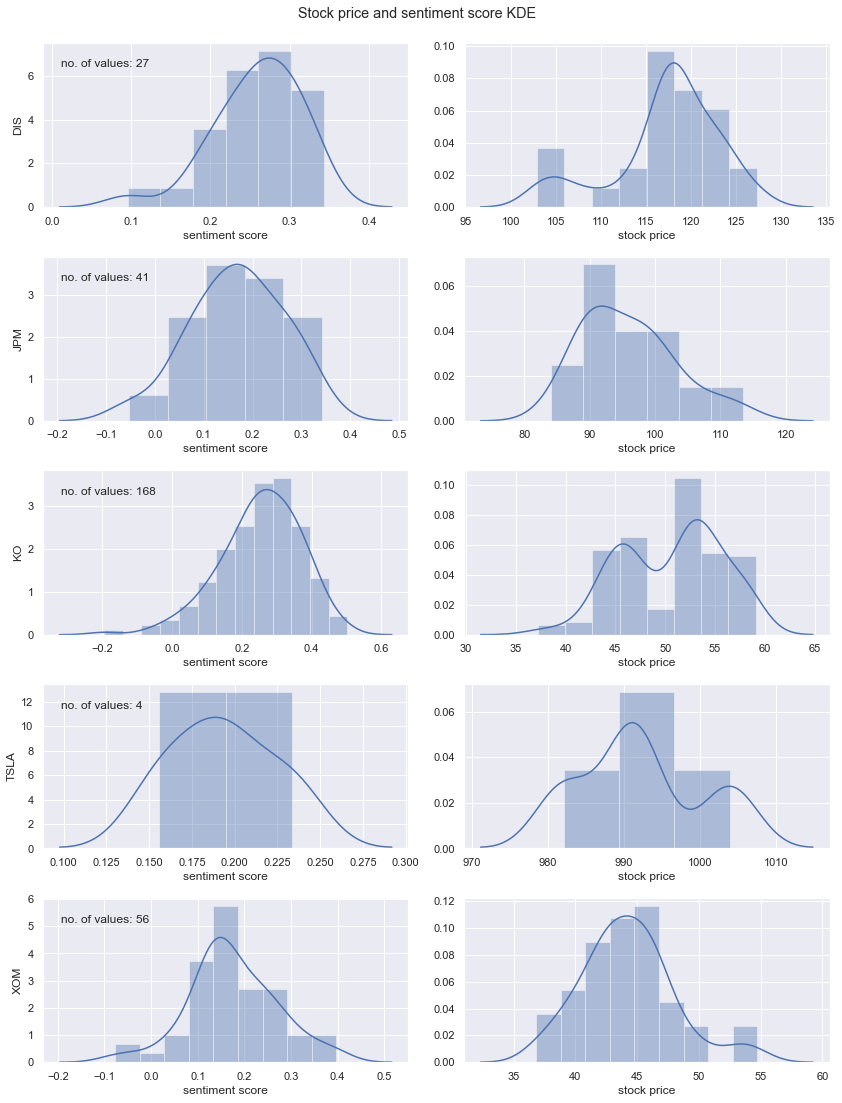

In [330]:
fig, axes = plt.subplots(5,2, figsize=(12,15))
for idx, ticker in enumerate(sent_price.keys()):
    sns.distplot(sent_price[ticker].sentiment_score, kde=True, ax=axes[idx,0])
    sns.distplot(sent_price[ticker].stock_price, kde=True, ax=axes[idx,1])
    axes[idx,0].set_ylabel(ticker)
    axes[idx,0].set_xlabel('sentiment score')
    axes[idx,1].set_xlabel('stock price')
    
    # add text box with observations count
    xmin, xmax = axes[idx,0].get_xbound()
    ymin, ymax = axes[idx,0].get_ybound()
    axes[idx,0].text(x=xmin+0.05*(xmax-xmin),\
                     y=0.85*ymax, s = f'no. of values: {sent_price[ticker].shape[0]}')
      
fig.suptitle('Stock price and sentiment score KDE', x=0.5, y=1.02)
plt.tight_layout()
plt.show()

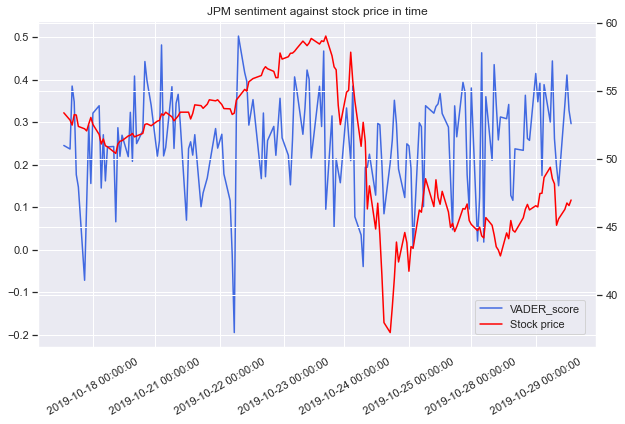

In [350]:
x = sent_price['KO'].index
y1 = sent_price['KO'].sentiment_score
y2 = sent_price['KO'].stock_price

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(x,y1, c='royalblue', label = 'VADER_score')
ax2 = ax1.twinx()
ax2.plot(x,y2, c ='red', label = 'Stock price')

ax1.set_xticklabels(x,rotation=30)
ax1.set_title('JPM sentiment against stock price in time')
fig.legend(bbox_to_anchor=(0.32, -0.2, 0.5, 0.5))
plt.show()

In [11]:
# use only adjusted close values for all tickers
df = stock_price.pivot(index='Date', columns='ticker', values = 'Adj Close')
df.index = pd.to_datetime(df.index)
df

ticker,DIS,JPM,KO,TSLA,XOM
Date,,,,,
2019-03-18,111.754234,103.049515,43.617306,269.489990,75.658966
2019-03-19,108.671898,102.674583,43.761383,267.470001,75.463013
2019-03-20,108.662018,100.482651,43.732567,273.600006,75.882919
2019-03-21,107.348083,98.896393,43.713352,274.019989,76.321495
2019-03-22,106.923279,95.906509,44.116779,264.529999,75.099091
...,...,...,...,...,...
2020-06-12,115.489998,99.870003,45.599998,935.280029,47.169998
2020-06-15,117.080002,101.250000,46.299999,990.900024,47.139999
2020-06-16,118.440002,102.059998,46.770000,982.130005,48.200001


Text(0.5, 0, 'Year')

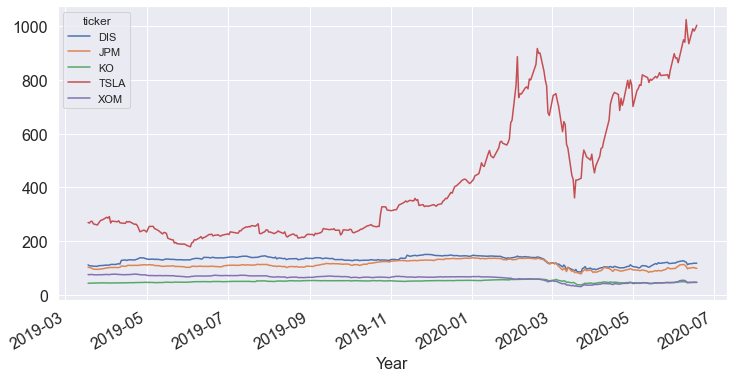

In [352]:
df.plot(figsize=(12,6), fontsize=16)
plt.xlabel('Year', fontsize=16)

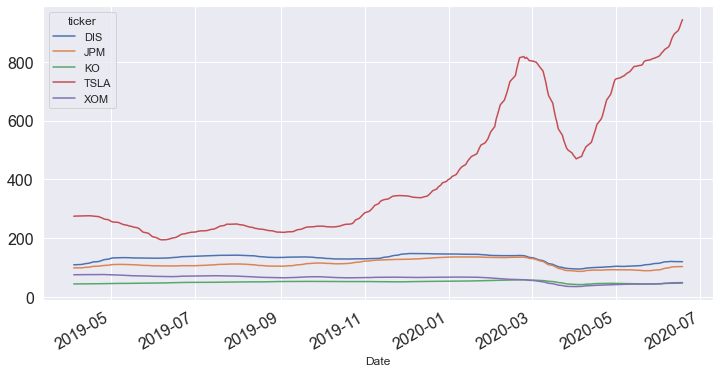

In [351]:
df.rolling(14).mean().plot(figsize=(12,6), fontsize=16)

## Granger Causality test

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

The null hypothesis for all four test is that the coefficients corresponding to past values of the second time series are zero.

------

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

So what does Granger’s Causality really test?

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

main source: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

In [477]:
maxlag=12
test = 'ssr-chi2test'

In [478]:
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [479]:
grangers_causality_matrix(df_train, variables = df_train.columns)

,stock_price_x,sentiment_score_x
stock_price_y,1.0000,0.3854
sentiment_score_y,0.0059,1.0000


The row are the response (y) and the columns are the predictor series (x).

If we take the value 0.1558 in (row 0, column 1), it refers to the p-value of the Granger’s Causality test for vs_score_x causing stock_price_y. 

If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

## VAR -  cointegration test

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.

But, what does Cointegration mean?

To understand that, you first need to know what is ‘order of integration’ (d).

Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

This is the basic premise on which Vector Autoregression(VAR) models is based on. So, it’s fairly common to implement the cointegration test before starting to build VAR models.

In [480]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [481]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [482]:
cointegration_test(df_train)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
stock_price ::  22.31     > 12.3212   =>   True
sentiment_score ::  0.2       > 4.1296    =>   False


### Train - Test split

In [548]:
# trial with KO
n_obs = 10
ticker = 'KO'

df_train = sent_price[ticker][0:-n_obs]
df_test = sent_price[ticker][-n_obs:]

In [549]:
print(df_train.shape)
print(df_test.shape)

(158, 2)
(10, 2)


### Standardize data

In [550]:
# I guess i do not need this, because the method does not work with distances
# from sklearn.preprocessing import StandardScaler

In [551]:
#scaler = StandardScaler()
#scaler.fit(X_train.values.reshape(-1,1))

In [552]:
# # StandardScaler requires data in the format of a column vector (n,1)
# X_train_scaled = scaler.transform(X_train.values.reshape(-1,1))
# # turn the scaled column vector back into a time series
# X_train_scaled = X_train_scaled.reshape(1,len(X_train_scaled))[0]
# X_train_scaled = pd.Series(X_train_scaled, index=X_train.index)

## Stationarity check - Augmented Dickey Fuller

Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity.

A stationary time series is one whose characteristics like mean and variance does not change over time.

We cant test for stationarity using a a suite of tests called unit-root tests. The popular ones are:

* Augmented Dickey-Fuller Test (ADF Test)
* KPSS test
* Philip-Perron test  

if a series is found to be non-stationary, you make it stationary by differencing the series once and repeat the test again until it becomes stationary.

In [553]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

The p-values are obtained through regression surface approximation from MacKinnon 1994, but using the updated 2010 tables. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

The autolag option and maxlag for it are described in Greene.

In [554]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [555]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "stock_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.9728
 No. Lags Chosen       = 9
 Critical value 1%     = -3.475
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.2986. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "sentiment_score" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.118
 No. Lags Chosen       = 0
 Critical value 1%     = -3.473
 Critical value 5%     = -2.88
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




The basis behind VAR is that each of the time series in the system influences each other. That is, we can predict the series with past values of itself along with other series in the system. Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.  

Granger’s causality Tests the null hypothesis that the coefficients of past values in the regression equation is zero. In simpler terms, the past values of time series (x) do not cause the other series (y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis. This has been performed on original data-set.

### First order diff

In [556]:
df_train_diff = df_train.diff().dropna()

In [557]:
df_train_diff.describe()

,stock_price,sentiment_score
count,157.000000,157.000000
mean,-0.037753,-0.000450
std,1.143372,0.148020
min,-4.961025,-0.445217
25%,-0.436039,-0.093380
50%,0.000000,-0.008390
75%,0.356758,0.102540
max,2.814430,0.514738


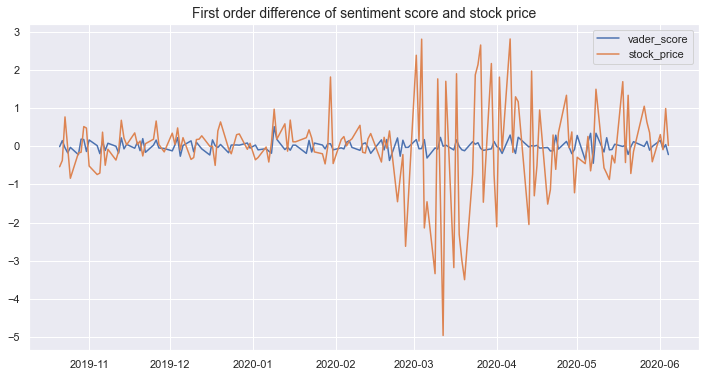

In [558]:
plt.figure(figsize=(12,6))
plt.plot(df_train_diff.index, df_train_diff.sentiment_score, label='vader_score')
plt.plot(df_train_diff.index, df_train_diff.stock_price, label='stock_price')
plt.title('First order difference of sentiment score and stock price', fontsize=14)
plt.legend()
plt.show()

In [559]:
# ADF Test on each column
for name, column in df_train_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "stock_price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.879
 No. Lags Chosen       = 8
 Critical value 1%     = -3.475
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0478. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "sentiment_score" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2112
 No. Lags Chosen       = 7
 Critical value 1%     = -3.475
 Critical value 5%     = -2.881
 Critical value 10%    = -2.577
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




## Normality check - is it necessary ?

In [560]:
stat, p = stats.normaltest(df_train_diff.stock_price)
alpha = 0.05
if p > alpha:
    print("Data looks Gaussian (fail to reject null hypothesis), p=",p)
else:
    print("Data does not looks Gaussian (reject null hypothesis), p=",p)

Data does not looks Gaussian (reject null hypothesis), p= 1.1151902007757104e-06


The nromality plot and historgram shows that the data is somewhat normally distributed

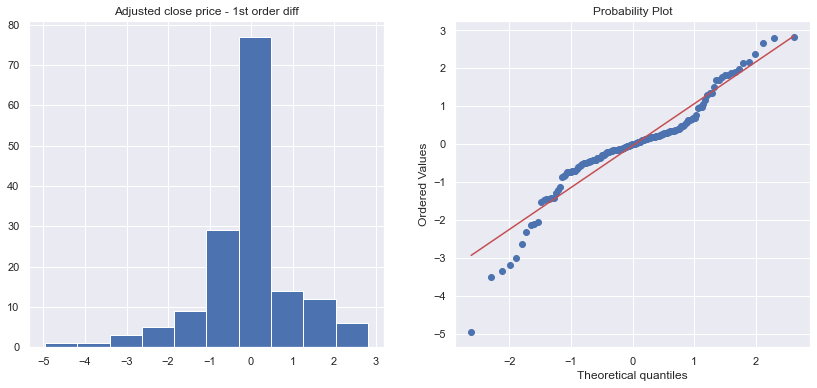

In [561]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.hist(df_train_diff.stock_price)
plt.title('Adjusted close price - 1st order diff')
plt.subplot(1,2,2)
stats.probplot(df_train_diff.stock_price, plot=plt)
plt.show()

## VAR model

Here each series is modeled by it’s own lag and other series' lag. 

* requires stationarity of the series

In [562]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [563]:
model = VAR(df_train_diff)
x = model.select_order(maxlags=12)
x.summary()

c:\Users\jaromir\Anaconda3\envs\disProject\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


,AIC,BIC,FPE,HQIC
0,-3.489,-3.448,0.03053,-3.472
1,-3.696,-3.573*,0.02482,-3.646
2,-3.751,-3.546,0.02349,-3.668*
3,-3.757,-3.469,0.02336,-3.640
4,-3.811,-3.441,0.02214,-3.660
5,-3.809,-3.357,0.02218,-3.625
6,-3.760,-3.226,0.02330,-3.543
7,-3.810,-3.194,0.02219,-3.559
8,-3.831,-3.133,0.02174,-3.547
9,-3.870*,-3.090,0.02092*,-3.553


In [564]:
model_fitted = model.fit(maxlags=9, ic='aic', verbose=True)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 9, BIC -> 1, FPE -> 9, HQIC -> 2>
Using 9 based on aic criterion


In [565]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 18, Jul, 2020
Time:                     16:46:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.12565
Nobs:                     148.000    HQIC:                  -3.58253
Log likelihood:          -93.7609    FPE:                  0.0203973
AIC:                     -3.89520    Det(Omega_mle):       0.0160200
--------------------------------------------------------------------
Results for equation stock_price
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.024182         0.090607           -0.267           0.790
L1.stock_price             0.025188         0.084251            0.299           0.765
L1.sentiment_score        -0.05838

## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

What does this mean to us?

If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

So, checking for serial correlation is to ensure that the model is sufficiently able to explain the variances and patterns in the time series.

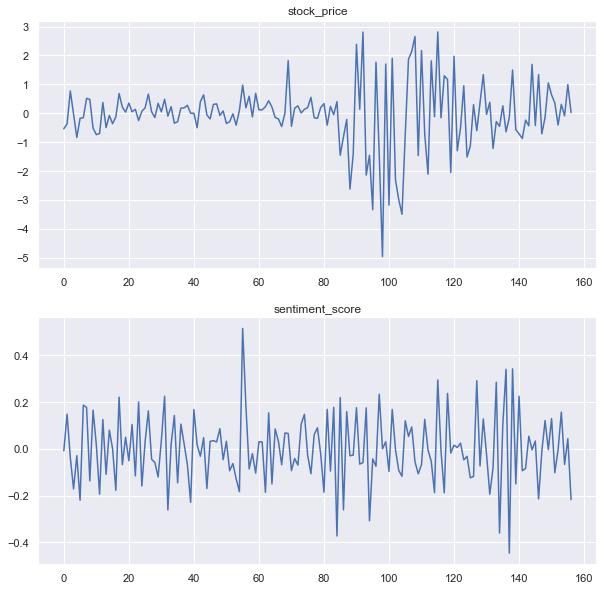

In [566]:
model_fitted.plot()
plt.show()

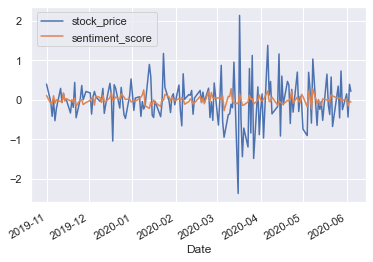

In [567]:
model_fitted.fittedvalues.plot()
plt.show()

## Durbin-Watson Statistic

The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no auto-correlation detected in the sample. Values from 0 to less than 2 indicate positive auto-correlation and values from 2 to 4 indicate negative auto-correlation. A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. Any value outside this range could be a cause for concern.

A stock price displaying positive auto-correlation would indicate that the price yesterday has a positive correlation on the price today — so if the stock fell yesterday, it is also likely that it falls today. A stock that has a negative auto-correlation, on the other hand, has a negative influence on itself over time — so that if it fell yesterday, there is a greater likelihood it will rise today.

In [568]:
from statsmodels.stats.stattools import durbin_watson

In [569]:
out = durbin_watson(model_fitted.resid)

In [570]:
for col, val in zip(df_train_diff.columns, out):
    print(col, ':', round(val, 2))

stock_price : 2.03
sentiment_score : 1.99


Prediction :
In order to forecast, the VAR model expects up to the lag order number of observations from the past data. This is because, the terms in the VAR model are essentially the lags of the various time series in the data-set, so we need to provide as many of the previous values as indicated by the lag order used by the model.


## Forecast using VAR

In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [571]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

9


In [573]:
df_test

,stock_price,sentiment_score
Date,,
2020-06-05,48.648037,0.388436
2020-06-08,49.401196,0.300600
2020-06-09,48.558849,0.444189
2020-06-10,48.182266,0.261548
2020-06-11,45.130001,0.196570
2020-06-12,45.599998,0.150705
2020-06-15,46.299999,0.340973
2020-06-16,46.770000,0.411093
2020-06-17,46.580002,0.328180


In [574]:
# Input data for forecasting
input_data = df_train_diff.values
print(input_data)

[[-5.36304474e-01 -8.39011236e-03]
 [-3.70536804e-01  1.48127059e-01]
 [ 7.70328522e-01 -3.72103922e-02]
 [-2.92510986e-02 -1.71186667e-01]
 [-8.38584900e-01 -2.89166667e-02]
 [-1.75521851e-01 -2.19490476e-01]
 [-1.56013489e-01  1.86915966e-01]
 [ 5.16799927e-01  1.77441176e-01]
 [ 4.77798462e-01 -1.36705263e-01]
 [-5.16799927e-01  1.65365263e-01]
 [-7.41077423e-01  1.74691667e-02]
 [-7.02068329e-01 -1.93537500e-01]
 [ 3.70536804e-01  1.25335256e-01]
 [-4.97299194e-01 -1.08606410e-01]
 [-7.80067444e-02  8.00234872e-02]
 [-3.60786438e-01  9.42363636e-04]
 [-1.26762390e-01 -1.77086364e-01]
 [ 6.82567596e-01  2.21262500e-01]
 [ 2.14523315e-01 -6.72798913e-02]
 [ 3.90014648e-02  4.96173913e-02]
 [ 3.51032257e-01 -5.05000000e-02]
 [ 4.87632751e-02  1.04325000e-01]
 [ 1.36512756e-01 -1.15356250e-01]
 [-2.53528595e-01  2.00731250e-01]
 [ 6.82525635e-02 -1.58852941e-01]
 [ 1.85276031e-01  3.02941176e-02]
 [ 6.63063049e-01  1.62674449e-01]
 [ 4.87556458e-02 -4.45206250e-02]
 [-1.47354126e-01 -5

In [575]:
# Forecast
fc = model_fitted.forecast(y=input_data, steps=n_obs)

In [576]:
df_forecast = pd.DataFrame(fc, index=df_test.index, columns=df_test.columns + '_1d')
df_forecast

,stock_price_1d,sentiment_score_1d
Date,,
2020-06-05,-0.060722,0.052629
2020-06-08,-0.007209,0.035215
2020-06-09,-0.052091,-0.019441
2020-06-10,0.281912,0.060761
2020-06-11,0.093592,-0.004308
2020-06-12,0.269188,0.019317
2020-06-15,-0.093059,0.006128
2020-06-16,0.043130,-0.032708
2020-06-17,-0.322177,-0.005114


## De differencing

In [577]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [578]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results

,stock_price_1d,sentiment_score_1d,stock_price_forecast,sentiment_score_forecast
Date,,,,
2020-06-05,-0.060722,0.052629,47.427849,0.227338
2020-06-08,-0.007209,0.035215,47.420641,0.262553
2020-06-09,-0.052091,-0.019441,47.368549,0.243112
2020-06-10,0.281912,0.060761,47.650462,0.303873
2020-06-11,0.093592,-0.004308,47.744054,0.299565
2020-06-12,0.269188,0.019317,48.013242,0.318882
2020-06-15,-0.093059,0.006128,47.920183,0.325009
2020-06-16,0.043130,-0.032708,47.963314,0.292301
2020-06-17,-0.322177,-0.005114,47.641137,0.287187


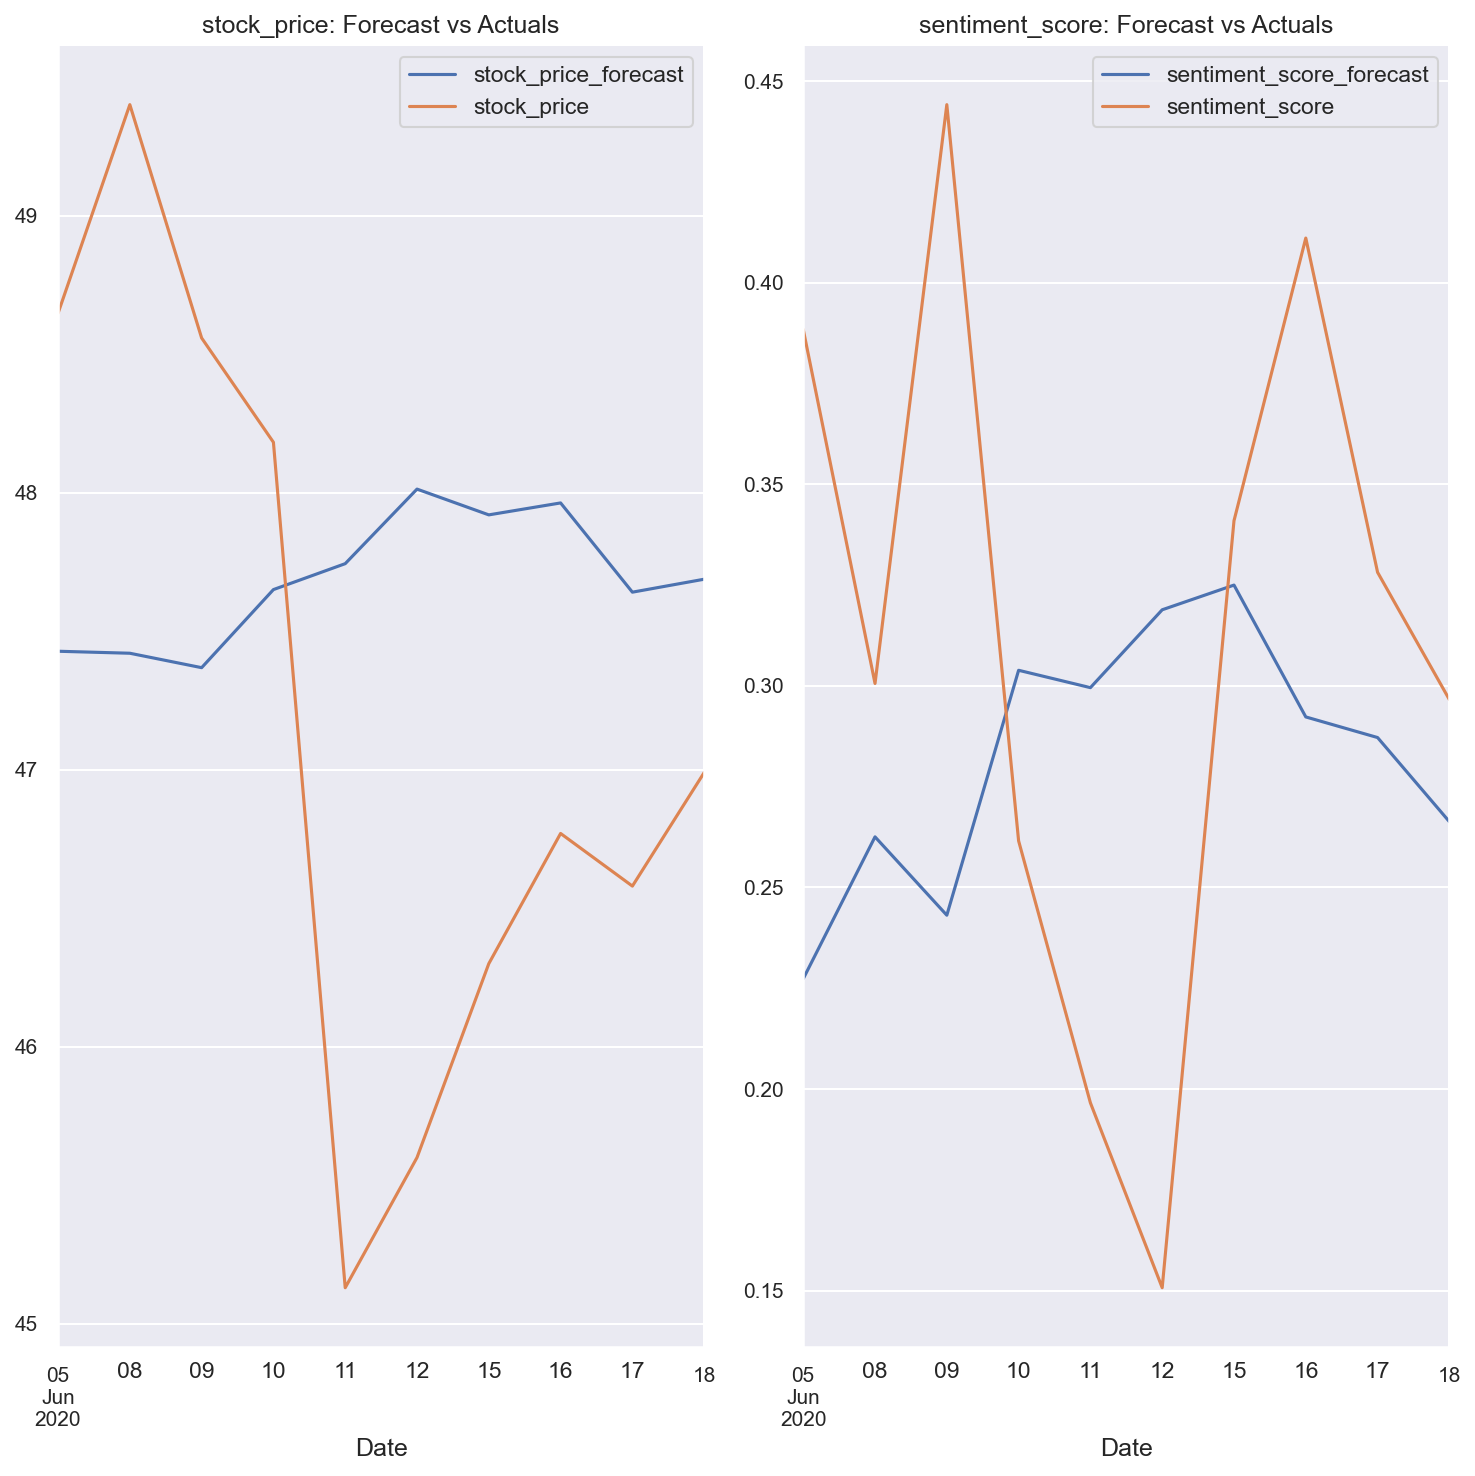

In [581]:
fig, axes = plt.subplots(nrows=int(len(df_train.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_train.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-n_obs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=10)

plt.tight_layout();

In [ ]:
from statsmodels.tsa.stattools import acf

In [547]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: stock_price')
accuracy_prod = forecast_accuracy(df_results['stock_price_forecast'].values, df_test['stock_price'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: sentiment_score')
accuracy_prod = forecast_accuracy(df_results['sentiment_score_forecast'].values, df_test['sentiment_score'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: stock_price
mape :  0.0263
me :  -1.2273
mae :  1.2273
mpe :  -0.0263
rmse :  1.2593
corr :  0.283
minmax :  0.0263

Forecast Accuracy of: sentiment_score
mape :  0.1327
me :  -0.0483
mae :  0.0483
mpe :  -0.1327
rmse :  0.0612
corr :  0.4614
minmax :  0.1327
